In [1]:
!python3 -V

Python 3.10.12


## Dependencies

In [2]:

!pip install transformer_lens
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
import transformer_lens
from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import plotly.express as px
import pandas as pd

## Defining the Autoencoder

In [4]:
cfg = {
    "seed": 49,
    "batch_size": 4096,
    "buffer_mult": 384,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 3e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 128,
    "d_mlp": 2048,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
}
cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

In [5]:
DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}
neuron_to_ablate = False
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to("cuda")

    def forward(self, x):
        global neuron_to_ablate
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        # if neuron_to_ablate:
        #     print(f"ablating {neuron_to_ablate}")
        #     if not (acts[:,:,neuron_to_ablate] == 0).any():
        #         raise Exception("Feature is not activated")
        #     acts[:,:,neuron_to_ablate] = 0
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

    # def get_version(self):
    #     return 1+max([int(file.name.split(".")[0]) for file in list(SAVE_DIR.iterdir()) if "pt" in str(file)])

    # def save(self):
    #     version = self.get_version()
    #     torch.save(self.state_dict(), SAVE_DIR/(str(version)+".pt"))
    #     with open(SAVE_DIR/(str(version)+"_cfg.json"), "w") as f:
    #         json.dump(cfg, f)
    #     print("Saved as version", version)

    # def load(cls, version):
    #     cfg = (json.load(open(SAVE_DIR/(str(version)+"_cfg.json"), "r")))
    #     pprint.pprint(cfg)
    #     self = cls(cfg=cfg)
    #     self.load_state_dict(torch.load(SAVE_DIR/(str(version)+".pt")))
    #     return self

    @classmethod
    def load_from_hf(cls, version):
        """
        Loads the saved autoencoder from HuggingFace.

        Version is expected to be an int, or "run1" or "run2"

        version 25 is the final checkpoint of the first autoencoder run,
        version 47 is the final checkpoint of the second autoencoder run.
        """
        if version=="run1":
            version = 25
        elif version=="run2":
            version = 47

        cfg = utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}_cfg.json")
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}.pt", force_is_torch=True))
        return self


## Utils

### Get Reconstruction Loss

In [6]:
def replacement_hook(mlp_post, hook, encoder):
    mlp_post_reconstr = encoder(mlp_post)[1]
    return mlp_post_reconstr

def mean_ablate_hook(mlp_post, hook):
    mlp_post[:] = mlp_post.mean([0, 1])
    return mlp_post

def zero_ablate_hook(mlp_post, hook):
    mlp_post[:] = 0.
    return mlp_post

@torch.no_grad()
def get_recons_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []
    for i in range(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        loss = model(tokens, return_type="loss")
        recons_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])
        # mean_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), mean_ablate_hook)])
        zero_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), zero_ablate_hook)])
        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(f"loss: {loss:.4f}, recons_loss: {recons_loss:.4f}, zero_abl_loss: {zero_abl_loss:.4f}")
    score = ((zero_abl_loss - recons_loss)/(zero_abl_loss - loss))
    print(f"Reconstruction Score: {score:.2%}")
    # print(f"{((zero_abl_loss - mean_abl_loss)/(zero_abl_loss - loss)).item():.2%}")
    return score, loss, recons_loss, zero_abl_loss

### Get Frequencies

In [7]:
# Frequency
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]

        _, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
        mlp_acts = cache[utils.get_act_name("post", 0)]
        mlp_acts = mlp_acts.reshape(-1, d_mlp)

        hidden = local_encoder(mlp_acts)[2]

        act_freq_scores += (hidden > 0).sum(0)
        total+=hidden.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores==0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

## Loading the Model

In [8]:
model = HookedTransformer.from_pretrained("gelu-1l").to(DTYPES[cfg["enc_dtype"]])
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

Loaded pretrained model gelu-1l into HookedTransformer
Changing model dtype to torch.float32


## Loading Data

In [12]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map (num_proc=10):   0%|          | 0/20000 [00:00<?, ? examples/s]

# Analysis

## Loading the Autoencoder

There are two runs on separate random seeds, along with a bunch of intermediate checkpoints

In [13]:
auto_encoder_run = "run1" # @param ["run1", "run2"]
encoder = AutoEncoder.load_from_hf(auto_encoder_run)

{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


## Using the Autoencoder

We run the model and replace the MLP activations with those reconstructed from the autoencoder, and get 91% loss recovered

In [53]:
_ = get_recons_loss(num_batches=20, local_encoder=encoder)

loss: 5.1225, recons_loss: 5.5278, zero_abl_loss: 9.9636
Reconstruction Score: 91.63%


## Rare Features Are All The Same

For each feature we can get the frequency at which it's non-zero (per token, averaged across a bunch of batches), and plot a histogram

In [17]:
freqs = get_freqs(num_batches = 200, local_encoder = encoder)

  0%|          | 0/200 [00:00<?, ?it/s]

Num dead tensor(0., device='cuda:0')


In [18]:
freqs[2124]


tensor(2.4414e-05, device='cuda:0')

In [19]:
# Add 1e-6.5 so that dead features show up as log_freq -6.5
log_freq = (freqs + 10**-6.5).log10()
px.histogram(utils.to_numpy(log_freq), title="Log Frequency of Features", histnorm='percent')

We see that it's clearly bimodal! Let's define rare features as those with freq < 1e-4, and look at the cosine sim of each feature with the average rare feature - we see that almost all rare features correspond to this feature!

In [20]:
# import torch
# from functools import partial
# import tqdm

# def get_difference_in_loss(original_loss_sum, ablated_loss_sum, total_activations):
#     if total_activations == 0:
#         return 0
#     # Calculate the average losses
#     feature_loss = original_loss_sum / total_activations
#     ablated_feature_loss = ablated_loss_sum / total_activations

#     # Calculate the percentage difference in loss
#     percentage_diff = ((ablated_feature_loss - feature_loss) / ablated_feature_loss) * 100
#     return percentage_diff

# @torch.no_grad()
# def get_activation_masks(num_batches=25, local_encoder=None, feature_idx=4700):
#     global neuron_to_ablate
#     if local_encoder is None:
#         local_encoder = encoder

#     # Accumulators for all batches
#     total_original_loss = 0
#     total_ablated_loss = 0
#     total_reconstruncted_loss = 0
#     total_activations_count = 0
#     feature_activation_frequency = 0
#     total_possible_activations = 0

#     for _ in tqdm.trange(num_batches):
#         tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
#         _, cache = model.run_with_cache(tokens, stop_at_layer=1)
#         mlp_acts = cache[utils.get_act_name("post", 0)]
#         hidden = local_encoder(mlp_acts)[2]  # (b, c, d_hidden)

#         # Check if the specific feature is activated (non-zero values)
#         feature_activations = hidden[..., feature_idx]  # (b, c)
#         feature_activations_mask = (feature_activations != 0).int()  # (b, c)
#         feature_mask_aligned = feature_activations_mask[:, :-1]  # Aligning the mask to the loss tensor shape

#         loss_per_token = model((tokens), return_type="loss", loss_per_token=True)

#         loss_with_reconstruction = model.run_with_hooks(tokens, loss_per_token=True, return_type="loss",
#                                                   fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])

#         neuron_to_ablate = feature_idx
#         loss_with_ablation = model.run_with_hooks(tokens, loss_per_token=True, return_type="loss",
#                                                   fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])
#         neuron_to_ablate = False

#         # Update the feature activation frequency
#         feature_activation_frequency += feature_mask_aligned.sum().item()

#         # Sum up the losses for the particular feature across all batches
#         total_original_loss += (loss_per_token * feature_mask_aligned.float()).sum().item()
#         total_reconstruncted_loss += (loss_with_reconstruction * feature_mask_aligned.float()).sum().item()
#         total_ablated_loss += (loss_with_ablation * feature_mask_aligned.float()).sum().item()
#         total_activations_count += feature_activations_mask.sum().item()
#         total_possible_activations += feature_activations_mask.numel()
#         print("frequency",total_activations_count/total_possible_activations)

#     # Calculate the improvement over all batches
#     improvement = get_difference_in_loss(total_reconstruncted_loss, total_ablated_loss, total_activations_count)

#     return (total_original_loss/total_activations_count, total_reconstruncted_loss/total_activations_count, total_ablated_loss/total_activations_count, feature_activation_frequency / total_possible_activations)

#     activation_frequency_fraction = feature_activation_frequency / total_possible_activations

#     return improvement, total_activations_count, activation_frequency_fraction

# # Example usage:
# loss_data = []
# loss_data.append(get_activation_masks(feature_idx = 1843))
# print(loss_data)



In [21]:


sorted_freqs, sorted_indices = torch.sort(freqs)

# Step 2: Calculate the indices for each decile
n = len(sorted_freqs)
decile_indices = [(n-1) * i // 10 for i in range(1, 10)]  # (n-1) to ensure the last index is within bounds

# Step 3: Add the first and the last index (0 and n-1) to cover all deciles including the extremes
decile_indices = [0] + decile_indices + [n-1]

# Step 4: Pick one element from each decile
# For simplicity, we choose the element at the decile boundary, but you could pick any within the decile
selected_freqs = sorted_freqs[decile_indices]
selected_indices = sorted_indices[decile_indices]

# Now you have the selected values from each decile and their original indices
print("Selected frequencies:", selected_freqs)
print("Original indices of selected frequencies:", selected_indices)


Selected frequencies: tensor([3.6621e-06, 4.0283e-05, 4.6387e-05, 5.1880e-05, 5.6763e-05, 6.2866e-05,
        9.4604e-05, 1.7810e-03, 4.0857e-03, 1.4902e-02, 5.6861e-01],
       device='cuda:0')
Original indices of selected frequencies: tensor([ 9026, 14090,  8626,  2340, 11518, 13500,  8941,  2036, 11958,  1440,
         1527], device='cuda:0')


In [22]:
import torch

# Suppose sorted_indices and sorted_freqs are already given from the previous steps

# Step 1: Identify the range for the 8th decile
start_index_8th_decile = decile_indices[3]
end_index_8th_decile = decile_indices[4] - 1

# Step 2: Randomly select 100 indices within this range
random_indices_8th_decile = torch.randint(low=start_index_8th_decile,
                                          high=end_index_8th_decile + 1,
                                          size=(50,))

# Step 3: Get the actual frequencies and indices from sorted_freqs and sorted_indices
random_freqs_8th_decile = sorted_freqs[random_indices_8th_decile]
random_original_indices_8th_decile = sorted_indices[random_indices_8th_decile]

# Now you have 100 randomly selected elements from the 8th decile
print("Randomly selected frequencies from the 8th decile:", random_freqs_8th_decile)
print("Original indices of the randomly selected frequencies:", random_original_indices_8th_decile)


Randomly selected frequencies from the 8th decile: tensor([5.3711e-05, 5.1880e-05, 5.5542e-05, 5.2490e-05, 5.3711e-05, 5.4321e-05,
        5.2490e-05, 5.3711e-05, 5.2490e-05, 5.5542e-05, 5.5542e-05, 5.1880e-05,
        5.4321e-05, 5.2490e-05, 5.2490e-05, 5.5542e-05, 5.1880e-05, 5.3101e-05,
        5.1880e-05, 5.3711e-05, 5.6763e-05, 5.6152e-05, 5.5542e-05, 5.1880e-05,
        5.3101e-05, 5.4321e-05, 5.2490e-05, 5.4321e-05, 5.4321e-05, 5.1880e-05,
        5.6152e-05, 5.6763e-05, 5.3101e-05, 5.6152e-05, 5.3101e-05, 5.5542e-05,
        5.3711e-05, 5.1880e-05, 5.6152e-05, 5.3101e-05, 5.3101e-05, 5.5542e-05,
        5.4321e-05, 5.6152e-05, 5.5542e-05, 5.1880e-05, 5.4321e-05, 5.3711e-05,
        5.3101e-05, 5.2490e-05], device='cuda:0')
Original indices of the randomly selected frequencies: tensor([ 1396, 12114,  5115,  5104,  3439,  2494,  1148,  3070, 10316, 12935,
          158, 15859,  4350, 11756,  4761,  1373,  7953,  5150, 13509, 13932,
         4888,  4961,  5871, 13638,  5150,  5701

In [24]:
import torch
from functools import partial
import tqdm


@torch.no_grad()
def get_activation_loss(num_batches=200, local_encoder=None, feature_idx=4700):
    global neuron_to_ablate
    if local_encoder is None:
        local_encoder = encoder

    # Accumulators for all batches
    total_original_loss = 0
    total_activations_count = 0
    feature_activation_frequency = 0
    total_possible_activations = 0
    activation_loss_pairs = []

    for _ in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        _, cache = model.run_with_cache(tokens, stop_at_layer=1)
        mlp_acts = cache[utils.get_act_name("post", 0)]
        hidden = local_encoder(mlp_acts)[2]  # (b, c, d_hidden)

        # Check if the specific feature is activated (non-zero values)
        feature_activations = hidden[..., feature_idx]  # (b, c)
        feature_activations_mask = (feature_activations != 0).int()  # (b, c)
        feature_mask_aligned = feature_activations_mask[:, :-1]  # Aligning the mask to the loss tensor shape

        loss_per_token = model((tokens), return_type="loss", loss_per_token=True)


        # Update the feature activation frequency
        feature_activation_frequency += feature_mask_aligned.sum().item()

        # Sum up the losses for the particular feature across all batches
        total_original_loss += (loss_per_token * feature_mask_aligned.float()).sum().item()
        total_activations_count += feature_activations_mask.sum().item()
        bool_mask = feature_mask_aligned == 1


        # b,c = feature_mask_aligned.shape
        # for i in range(b):
        #   for j in range(c):
        #     if feature_mask_aligned[i][j] == 1:
        #       acts.append([feature_activations[i][j], loss_per_token[i][j]])
        #       print(acts[-1])

        # Extend the activation_loss_pairs list with the non-zero (activation, loss) pairs

        activation_loss_pairs.extend(torch.stack((feature_activations[:,:-1][bool_mask], loss_per_token[bool_mask]), dim=1))




        total_possible_activations += feature_activations_mask.numel()
        # print("frequency",total_activations_count/total_possible_activations)



    activation_frequency_fraction = feature_activation_frequency / total_possible_activations
    print(f"Total activations = {feature_activation_frequency}")
    print(f"avg loss {total_original_loss/total_activations_count}")
    return [total_original_loss/total_activations_count, activation_frequency_fraction, activation_loss_pairs]

# Example usage:
loss_data = []
feature_idx = 2124
print(freqs[feature_idx])
loss_data.append(get_activation_loss(feature_idx=feature_idx))





tensor(2.4414e-05, device='cuda:0')


100%|██████████| 200/200 [01:45<00:00,  1.90it/s]

Total activations = 43
avg loss 3.756884597068609


In [25]:
loss_data[-1][-1]
c = []
b = []
for i in loss_data[-1][-1]:
  c.append(i[1].item())
  b.append(i[0].item())
print(sum(c)/len(c), torch.tensor(c).mean(), torch.tensor(b).median())

3.756884583114845 tensor(3.7569) tensor(0.6257)


In [26]:
import plotly.graph_objects as go

# Assume c and b are already defined PyTorch tensors or lists
# If they are tensors, we need to convert them to numpy arrays.
# Make sure they are on the CPU before converting to numpy arrays.
c_np = c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else np.array(c)
b_np = b.detach().cpu().numpy() if isinstance(b, torch.Tensor) else np.array(b)

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=b_np, y=c_np, mode='markers'))

# Update layout for a better look
fig.update_layout(
    title='Relationship between Feature Activation and Loss',
    xaxis_title='Activation of Feature',
    yaxis_title='Loss',
    hovermode='closest'  # Show info when you hover over a point
)

# Show the plot
fig.show()


Let's go and investigate a non rare feature, feature 7

Let's run the model on some text and then use the autoencoder to process the MLP activations

In [114]:
import torch
from functools import partial
import tqdm

@torch.no_grad()
def get_activation_loss_for_all_features(num_batches=200, local_encoder=None, feature_idx=4700):
    global neuron_to_ablate
    if local_encoder is None:
        local_encoder = encoder

    # Accumulators for all batches
    total_activations_count = 0
    feature_activation_frequency = 0
    total_possible_activations = 0
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).cuda()
    act_loss_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).cuda()

    for _ in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        _, cache = model.run_with_cache(tokens, stop_at_layer=1)
        mlp_acts = cache[utils.get_act_name("post", 0)]
        hidden = local_encoder(mlp_acts)[2]  # (b, c, d_hidden)


        # Get the dimensions
        b, c, d = hidden.shape

        # Check if the specific feature is activated (non-zero values)
        feature_activations_mask = (hidden > 0).int()  # (b, c, d_hidden)

        # Calculate loss per token (assuming model returns loss of shape (b, c-1))
        loss_per_token = model(tokens, return_type="loss", loss_per_token=True)  # (b, c-1)

        # Compute the total number of activations for each feature across all batches
        activations_count = feature_activations_mask.sum(dim=[0, 1])  # (d_hidden)

        # Compute the loss for each feature where it's activated
        # Align the masks to the loss tensor shape by trimming the last column
        feature_mask_aligned = feature_activations_mask[:, :-1, :]  # (b, c-1, d_hidden)

        # Multiply the loss by the aligned mask, sum across batches and sequence length
        feature_loss = (loss_per_token.unsqueeze(-1) * feature_mask_aligned.float()).sum(dim=[0, 1])  # (d_hidden)



        # Update scores
        act_freq_scores += activations_count
        act_loss_scores += feature_loss

        total_possible_activations += b * (c - 1)

    # # Normalize scores
    # act_freq_scores /= total_possible_activations
    # act_loss_scores /= total_activations_count

    return [act_freq_scores/total_possible_activations, act_loss_scores/act_freq_scores]

# Example usage:
loss_data = []
feature_idx = 2124
# Assuming freqs is defined somewhere in the code with the relevant context.
# print(freqs[feature_idx])
freqs, loss = get_activation_loss_for_all_features(feature_idx=feature_idx)


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


In [ ]:
loss[5709]

tensor(1.8965, device='cuda:0')

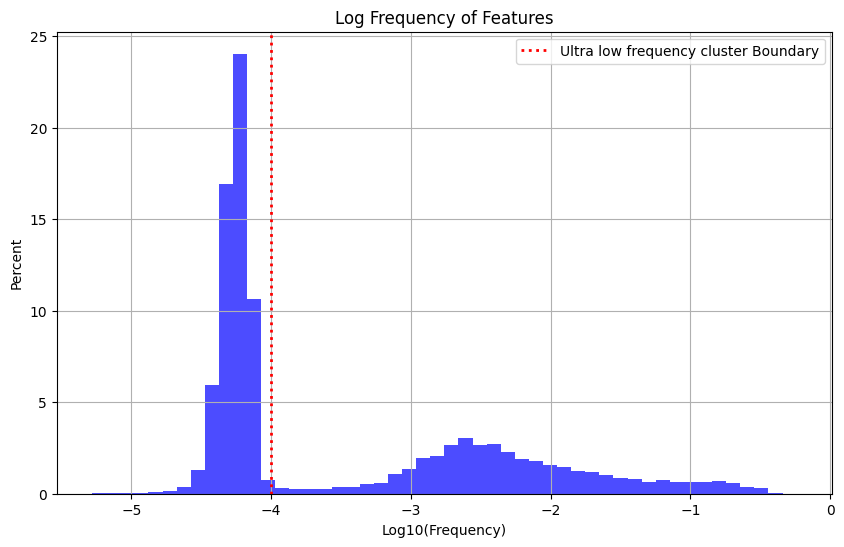

In [36]:
import matplotlib.pyplot as plt
import numpy as np


# Calculate log frequencies
log_freq = np.log10(freqs.cpu() + 10**-6.5)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(log_freq, bins=50, weights=np.ones(len(log_freq)) / len(log_freq) * 100, color='blue', alpha=0.7)
plt.title("Log Frequency of Features")
plt.xlabel("Log10(Frequency)")
plt.ylabel("Percent")
plt.grid(True)

# Add a vertical dotted red line at 1e-4 (log10(1e-4) = -4)
plt.axvline(x=np.log10(1e-4), color='red', linestyle='dotted', linewidth=2, label='Ultra low frequency cluster Boundary')



plt.legend()
plt.show()


In [ ]:
px.histogram(utils.to_numpy(loss), title="Log Frequency of Features", histnorm='percent')

In [47]:
import plotly.express as px
import numpy as np

# Convert tensors to numpy arrays after moving them to CPU
freqs_np = freqs.cpu().detach().numpy()
loss_np = loss.cpu().detach().numpy()

fig = px.scatter(x=freqs_np, y=loss_np, labels={'x':'Frequency of Feature Activation', 'y':'Average Loss when Feature Activated'}, title='Relationship between Feature Frequency and Loss (Log Scale)')
fig.update_layout(xaxis_type="log")  # Set the x-axis to a log scale
fig.show()


In [55]:
# Load the loss data from the uploaded file
loss = loss.cpu()
log_freq_np = np.log10(freqs.cpu() + 10**-6.5)

# Convert the indices provided to a list
indices = [11950, 3560, 2124, 15501, 9686]

freq_indices = np.arange(len(freqs_np))

# Now we'll create a new column for our scatter plot to mark the special points
# Initialize the color array with a default value
colors = np.array(['blue']*len(log_freq_np))
# Change the color for the specified indices
colors[indices] = 'orange'

# Create the interactive scatter plot using Plotly, marking the provided indices with a different color
fig = px.scatter(x=log_freq_np, y=loss.cpu().numpy(), title="Scatter Plot of Features",
                 labels={'x':'Log10(Frequency)', 'y': 'Average Loss when Feature is Activated', 'freq_idx': 'Feature Index'}, color=colors, hover_data={'feature_idx': freq_indices},)

# Add a vertical line for the boundary at 1e-4
fig.add_vline(x=np.log10(1e-4), line_dash="dot", line_color="red", annotation_text="Cluster Boundary")

# Show the figure
fig.show()



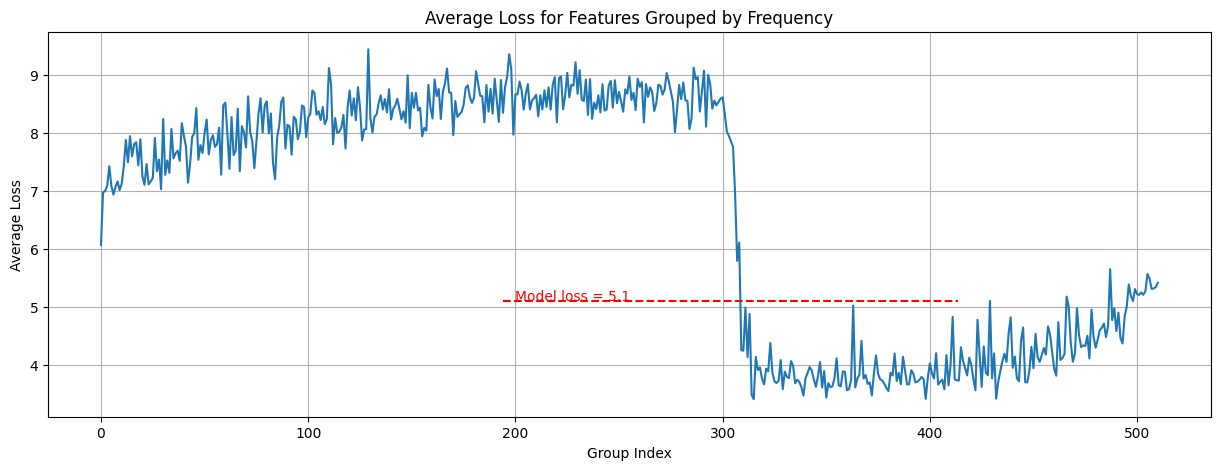

In [118]:
# Sort the features by frequency and get the sorted indices

freqs_data_cpu = freqs.cpu()
loss_data_cpu = loss.cpu()
sorted_indices = np.argsort(freqs_data_cpu.numpy())

# Divide the sorted features into 1000 groups
n_groups = 500
group_size = len(sorted_indices) // n_groups
groups = [sorted_indices[i:i + group_size] for i in range(0, len(sorted_indices), group_size)]

# Ensure that we have 1000 groups by adding the remaining features to the last group if necessary
if len(groups) > n_groups:
    groups[-2] = np.concatenate((groups[-2], groups[-1]))
    groups.pop()

# Calculate the average loss for each group
avg_loss_groups = [loss_data_cpu[group].mean().item() for group in groups]


#print(avg_loss_groups)
# Re-plotting the average loss for each group with the modified horizontal line
plt.figure(figsize=(15, 5))
plt.plot(avg_loss_groups)
plt.axhline(y=5.1, color='red', linestyle='--', xmin=200/len(avg_loss_groups), xmax=400/len(avg_loss_groups))
plt.text(200, 5.1, 'Model loss = 5.1', color='red')
plt.title('Average Loss for Features Grouped by Frequency')
plt.xlabel('Group Index')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


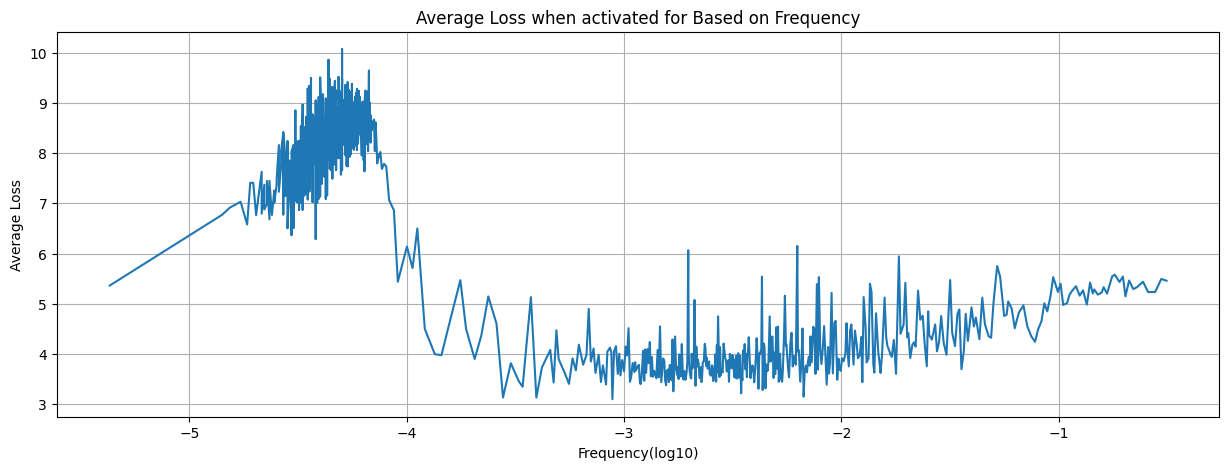

In [119]:
# Sort the features by frequency and get the sorted indices
import math
freqs_data_cpu = freqs.cpu()
loss_data_cpu = loss.cpu()
sorted_indices = np.argsort(freqs_data_cpu.numpy())

# Divide the sorted features into 1000 groups
n_groups = 1000
group_size = len(sorted_indices) // n_groups
groups = [sorted_indices[i:i + group_size] for i in range(0, len(sorted_indices), group_size)]

# Ensure that we have 1000 groups by adding the remaining features to the last group if necessary
if len(groups) > n_groups:
    groups[-2] = np.concatenate((groups[-2], groups[-1]))
    groups.pop()

# Calculate the average loss for each group
avg_loss_groups = [loss_data_cpu[group].mean().item() for group in groups]

freqs_x = [math.log(freqs_data_cpu[group[0]], 10) for group in groups]


#print(avg_loss_groups)

# Plot the average loss for each group
plt.figure(figsize=(15, 5))
plt.plot(freqs_x, avg_loss_groups)
plt.title('Average Loss when activated for Based on Frequency')
plt.xlabel('Frequency(log10)')
plt.ylabel('Average Loss')
plt.grid(True)





plt.show()


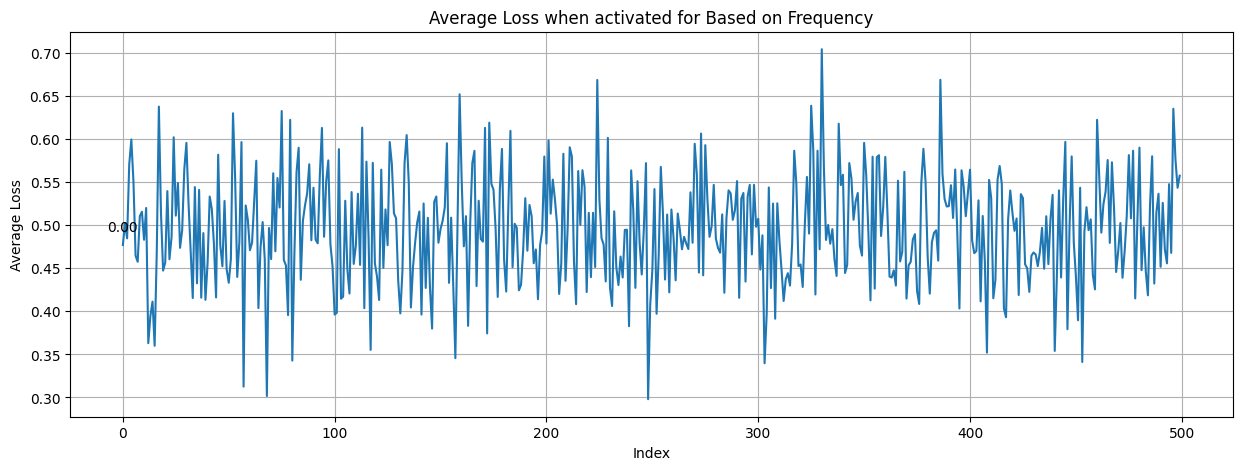

In [112]:
import numpy as np
import matplotlib.pyplot as plt


# Sort the features by frequency and get the sorted indices
sorted_indices = np.argsort(freqs)

# Divide the sorted features into 500 groups
n_groups = 500
group_size = len(sorted_indices) // n_groups
groups = [sorted_indices[i:i + group_size] for i in range(0, len(sorted_indices), group_size)]

# Ensure that we have 500 groups by adding the remaining features to the last group if necessary
if len(groups) > n_groups:
    groups[-2] = np.concatenate((groups[-2], groups[-1]))
    groups.pop()

# Calculate the average loss for each group
avg_loss_groups = [loss[group].mean() for group in groups]

# Plot the average loss for each group
plt.figure(figsize=(15, 5))
plt.plot(avg_loss_groups)
plt.title('Average Loss when activated for Based on Frequency')
plt.xlabel('Index')
plt.ylabel('Average Loss')
plt.grid(True)

# Add freqs[0], freqs[100], freqs[200]... freqs[500] to the top right of the graph
# We will take the freqs at positions that are multiples of the group size
indices_to_annotate = range(0, len(freqs), group_size)
freqs_to_annotate = freqs[sorted_indices[indices_to_annotate]]

# Annotating the specified frequencies on the graph
for i, (x, y) in enumerate(zip(indices_to_annotate, avg_loss_groups)):
    if i % (n_groups // 5) == 0:  # Annotate every 100th index to avoid clutter
        plt.annotate(f'{freqs_to_annotate[i]:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


In [120]:
indices = [11950, 3560, 2124, 15501, 9686]
for indice in indices:
  print(indice, freqs[indice])

In [122]:
for indice in indices:
  print(indice, freqs[indice])

11950 tensor(5.2904e-05, device='cuda:0')
3560 tensor(2.7682e-05, device='cuda:0')
2124 tensor(2.0300e-05, device='cuda:0')
15501 tensor(4.3061e-05, device='cuda:0')
9686 tensor(4.5522e-05, device='cuda:0')


In [133]:
import torch
import pandas as pd



indices = [11950, 3560, 2124, 15501, 9686]

# Calculate the percentiles for the given indices
percentile_data = []
for index in indices:
    value = freqs[index].item()
    less_than = torch.lt(freqs, value).sum().item()
    percentile = 100.0 * less_than / len(freqs)
    percentile_data.append((index, "{:.1e}".format(value), percentile))

# Convert the list to a DataFrame for better visualization
df = pd.DataFrame(percentile_data, columns=['Feature', 'Frequency', 'Percentile'])

# Sort the DataFrame by the 'Frequency' column
df_sorted = df.sort_values(by='Frequency')

df_sorted


,Feature,Frequency,Percentile
2,2124,2.0e-05,0.598145
1,3560,2.8e-05,3.247070
3,15501,4.3e-05,24.005127
4,9686,4.6e-05,28.637695
0,11950,5.3e-05,42.089844
